# Google Colab 기본 설정

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import yaml, os

extract_path = "/content/drive/MyDrive/final year car paint defect.v1i.yolov8_bbox/"

yaml_path = os.path.join(extract_path, "data.yaml")
with open(yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)

print(data_yaml)

# 클래스명
class_names = data_yaml['names']
print("클래스 목록:", class_names)



{'train': '../train/images', 'val': '../valid/images', 'test': '../test/images', 'nc': 4, 'names': ['dirt', 'runs', 'scratch', 'water marks'], 'roboflow': {'workspace': 'poli-h7nww', 'project': 'final-year-car-paint-defect', 'version': 1, 'license': 'CC BY 4.0', 'url': 'https://universe.roboflow.com/poli-h7nww/final-year-car-paint-defect/dataset/1'}}
클래스 목록: ['dirt', 'runs', 'scratch', 'water marks']


데이터 프레임 생성

In [ ]:
import glob
import pandas as pd

label_dir = os.path.join(extract_path, "train", "labels")

bbox_data = []
for file in glob.glob(f"{label_dir}/*.txt"):
    with open(file, 'r') as f:
        for line in f:
            cls_id, x, y, w, h = map(float, line.strip().split())
            bbox_data.append([int(cls_id), x, y, w, h])

df = pd.DataFrame(bbox_data, columns=["class_id", "x_center", "y_center", "width", "height"])
df["class_name"] = df["class_id"].apply(lambda x: class_names[x])
df["area"] = df["width"] * df["height"]
df["aspect_ratio"] = df["width"] / df["height"]

print(df)


      class_id  x_center  y_center     width    height   class_name      area  \
0            1  0.355903  0.335286  0.457899  0.641276         runs  0.293640   
1            0  0.027344  0.300000  0.018750  0.021094         dirt  0.000396   
2            0  0.775000  0.210156  0.016406  0.035937         dirt  0.000590   
3            1  0.514865  0.627441  0.346137  0.616862         runs  0.213519   
4            2  0.395783  0.714417  0.116219  0.569174      scratch  0.066149   
...        ...       ...       ...       ...       ...          ...       ...   
1027         3  0.702344  0.248438  0.033594  0.057031  water marks  0.001916   
1028         3  0.771094  0.358594  0.048438  0.089844  water marks  0.004352   
1029         3  0.815625  0.220312  0.048438  0.057031  water marks  0.002762   
1030         3  0.814063  0.337500  0.029687  0.057031  water marks  0.001693   
1031         3  0.335938  0.498437  0.083594  0.107813  water marks  0.009012   

      aspect_ratio  
0     

# 데이터분석

In [ ]:
from IPython.display import display

display(df.info())
display(df.describe())
display(df.describe().T[["min", "25%", "50%", "75%", "max"]])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032 entries, 0 to 1031
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   class_id      1032 non-null   int64  
 1   x_center      1032 non-null   float64
 2   y_center      1032 non-null   float64
 3   width         1032 non-null   float64
 4   height        1032 non-null   float64
 5   class_name    1032 non-null   object 
 6   area          1032 non-null   float64
 7   aspect_ratio  1032 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 64.6+ KB


None

,class_id,x_center,y_center,width,height,area,aspect_ratio
count,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000,1032.000000
mean,1.298450,0.518240,0.466452,0.136384,0.179295,0.050928,0.852250
std,1.249666,0.242740,0.227418,0.180339,0.219000,0.096087,0.813142
min,0.000000,0.010937,0.010937,0.004687,0.006250,0.000049,0.040477
25%,0.000000,0.377930,0.292969,0.016406,0.025781,0.000396,0.521739
50%,1.000000,0.514062,0.483594,0.048047,0.073438,0.003951,0.665694
75%,3.000000,0.692209,0.618693,0.196713,0.258063,0.048801,0.848197
max,3.000000,0.995313,0.990625,0.991211,0.936002,0.830997,8.313649


,min,25%,50%,75%,max
class_id,0.000000,0.000000,1.000000,3.000000,3.000000
x_center,0.010937,0.377930,0.514062,0.692209,0.995313
y_center,0.010937,0.292969,0.483594,0.618693,0.990625
width,0.004687,0.016406,0.048047,0.196713,0.991211
height,0.006250,0.025781,0.073438,0.258063,0.936002
area,0.000049,0.000396,0.003951,0.048801,0.830997
aspect_ratio,0.040477,0.521739,0.665694,0.848197,8.313649


폴리곤 vs 바운딩박스 수

In [3]:
import os

base_label_dir = '/content/drive/MyDrive/final year car paint defect.v1i.yolov8/train/labels'

bbox_count = 0
polygon_count = 0
total_files = 0

for fname in os.listdir(base_label_dir):
    if not fname.endswith('.txt'):
        continue
    total_files += 1
    path = os.path.join(base_label_dir, fname)
    with open(path, 'r') as f:
        for line in f:
            num_values = len(line.strip().split())
            if num_values == 5:
                bbox_count += 1
            elif num_values > 5 and num_values % 2 == 1:
                polygon_count += 1
            else:
                print(f"[⚠️형식오류] {fname} → {line.strip()}")

print("=== 📊 라벨 형식 통계 ===")
print(f"총 라벨 파일 수        : {total_files}")
print(f"바운딩 박스 개수 (bbox): {bbox_count}")
print(f"폴리곤 개수 (polygon)  : {polygon_count}")


=== 📊 라벨 형식 통계 ===
총 라벨 파일 수        : 240
바운딩 박스 개수 (bbox): 698
폴리곤 개수 (polygon)  : 334


#데이터 탐색

In [ ]:
# 클래스별 개수
class_counts = df["class_name"].value_counts()
print("클래스별 객체 수:\n", class_counts)

# 이미지당 객체 수 계산
objects_per_image = {}
for file in glob.glob(os.path.join(label_dir, "*.txt")):
    with open(file, 'r') as f:
        count = len(f.readlines())
        image_id = os.path.basename(file).replace(".txt", "")
        objects_per_image[image_id] = count
df_img = pd.DataFrame(list(objects_per_image.items()), columns=["image_id", "object_count"])
print("\n이미지당 객체 수 통계:")
print(df_img["object_count"].describe())

# 클래스별 평균 box 크기
avg_box_size = df.groupby("class_name")[["width", "height", "area"]].mean()
print("\n클래스별 평균 box 크기:")
print(avg_box_size)

# 이상치 예시 (면적이 큰 박스들)
outliers = df[df["area"] > 0.2]
print("\n면적이 큰 이상치 예시:")
print(outliers.sort_values("area", ascending=False).head(5))


클래스별 객체 수:
 class_name
dirt           437
water marks    260
scratch        225
runs           110
Name: count, dtype: int64

이미지당 객체 수 통계:
count    240.00000
mean       4.30000
std        4.08815
min        1.00000
25%        2.00000
50%        3.00000
75%        5.00000
max       26.00000
Name: object_count, dtype: float64

클래스별 평균 box 크기:
                width    height      area
class_name                               
dirt         0.015882  0.025154  0.000439
runs         0.429843  0.516680  0.236133
scratch      0.290831  0.387283  0.103754
water marks  0.081106  0.115643  0.011716

면적이 큰 이상치 예시:
     class_id  x_center  y_center     width    height class_name      area  \
880         1  0.487739  0.574056  0.975477  0.851888       runs  0.830997   
99          1  0.538737  0.441895  0.673828  0.883789       runs  0.595522   
714         1  0.398763  0.623372  0.738932  0.748698       runs  0.553237   
344         1  0.334744  0.606608  0.669488  0.786784       runs  0.526742   

#데이터 시각화

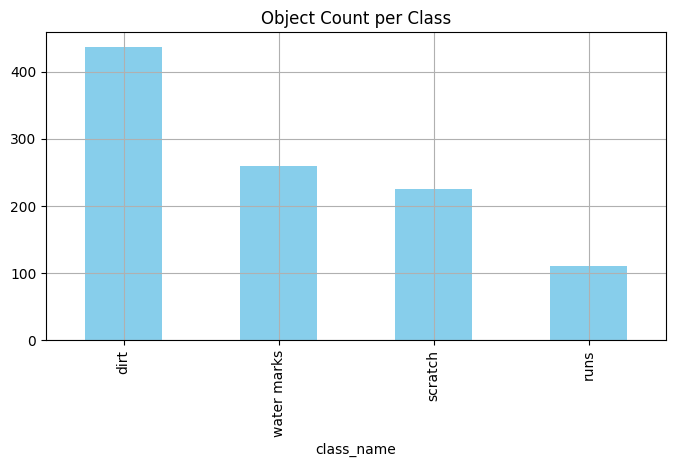

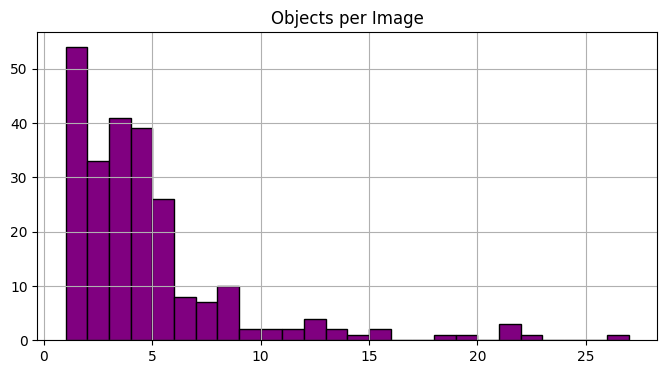

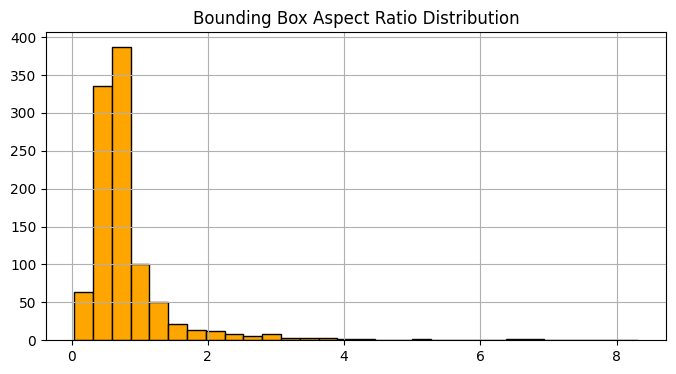

<Figure size 1000x400 with 0 Axes>

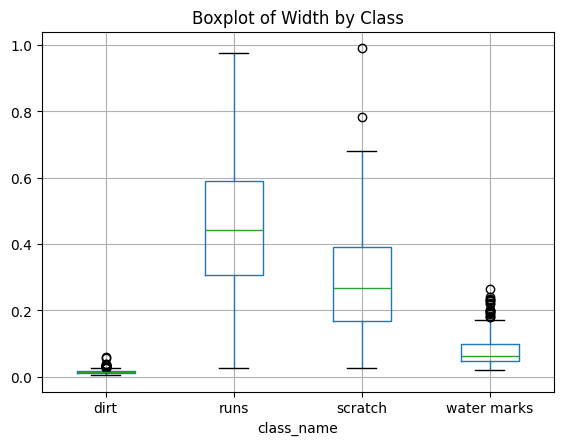

<Figure size 1000x400 with 0 Axes>

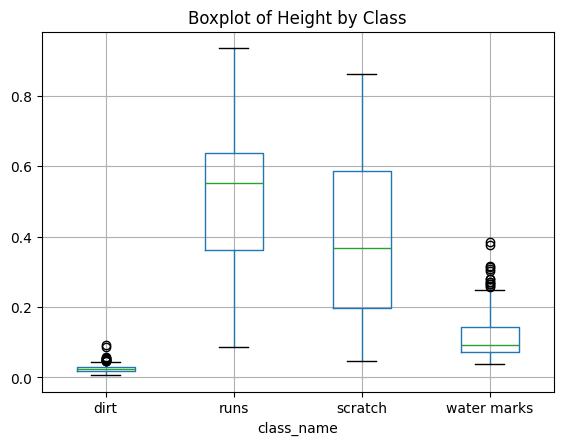

,class_id,x_center,y_center,width,height,class_name,area,aspect_ratio
880,1,0.487739,0.574056,0.975477,0.851888,runs,0.830997,1.145077
99,1,0.538737,0.441895,0.673828,0.883789,runs,0.595522,0.762431
714,1,0.398763,0.623372,0.738932,0.748698,runs,0.553237,0.986956
344,1,0.334744,0.606608,0.669488,0.786784,runs,0.526742,0.850917
278,1,0.444878,0.668687,0.766059,0.630994,runs,0.483379,1.214051


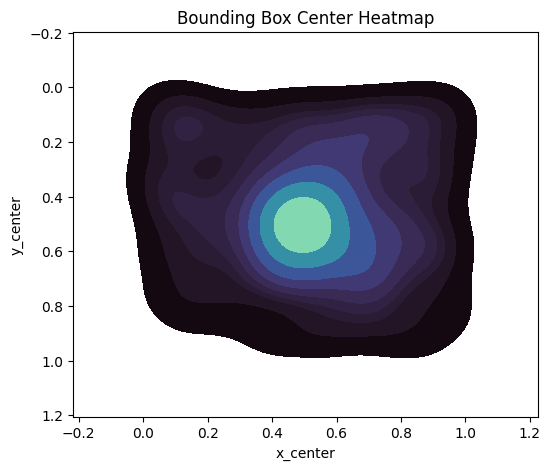

In [ ]:
import matplotlib.pyplot as plt

# 클래스별 객체 수
plt.figure(figsize=(8, 4))
class_counts.plot(kind="bar", color="skyblue")
plt.title("Object Count per Class")
plt.grid(True)
plt.show()

# 이미지당 객체 수 히스토그램
plt.figure(figsize=(8, 4))
plt.hist(df_img["object_count"], bins=range(1, df_img["object_count"].max() + 2), color="purple", edgecolor="black")
plt.title("Objects per Image")
plt.grid(True)
plt.show()

# 바운딩박스 비율 분포
plt.figure(figsize=(8, 4))
plt.hist(df["aspect_ratio"], bins=30, color="orange", edgecolor="black")
plt.title("Bounding Box Aspect Ratio Distribution")
plt.grid(True)
plt.show()

# 박스 크기 boxplot (width / height)
plt.figure(figsize=(10, 4))
df.boxplot(column="width", by="class_name")
plt.title("Boxplot of Width by Class")
plt.suptitle("")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
df.boxplot(column="height", by="class_name")
plt.title("Boxplot of Height by Class")
plt.suptitle("")
plt.grid(True)
plt.show()

# 이상치 출력
display(outliers.sort_values("area", ascending=False).head(5))

#밀도 분포(heatmap) 시각화
import seaborn as sns
plt.figure(figsize=(6,5))
sns.kdeplot(data=df, x="x_center", y="y_center", fill=True, cmap="mako", thresh=0.05)
plt.title("Bounding Box Center Heatmap")
plt.gca().invert_yaxis()  # 이미지 좌표 기준
plt.show()

이미지 파일 예시

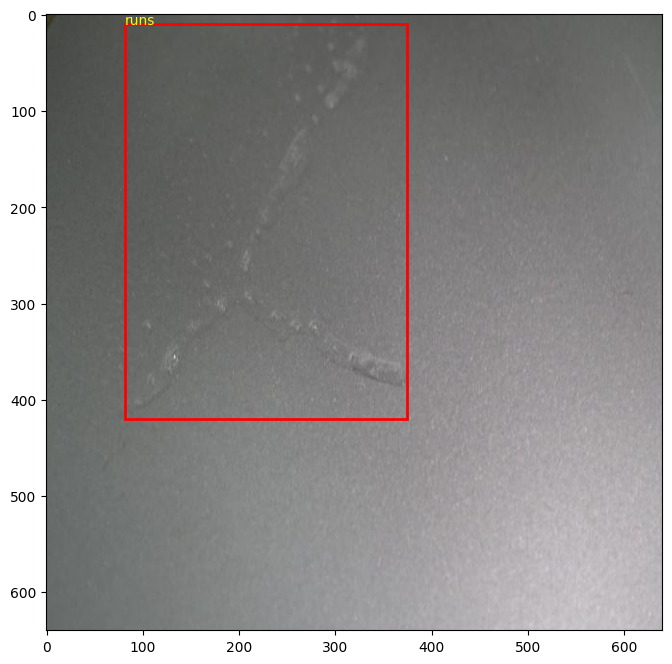

In [ ]:
import cv2
from matplotlib import patches

def visualize_sample(image_path, label_path):
    img = cv2.imread(image_path)[:,:,::-1]
    h, w, _ = img.shape

    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.imshow(img)

    with open(label_path, 'r') as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.split())
            cls = int(cls)

            # YOLO 좌표 → 픽셀 좌표 변환
            x1 = (x - bw/2) * w
            y1 = (y - bh/2) * h
            rect = patches.Rectangle((x1, y1), bw*w, bh*h,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1, class_names[cls], color='yellow', fontsize=10)

    plt.show()

# 샘플 1개 시각화
sample_img = train_img[0]
sample_lbl = sample_img.replace("images", "labels").replace(".jpg", ".txt")
visualize_sample(sample_img, sample_lbl)
